# Análisis del entrenamiento

In [32]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from src.autoencoders import * 
from src.training import *
from src.training import train_model
from src.cae_model import S15


## data load

In [34]:
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                        shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

## train

In [5]:
# Configuración de entrenamiento
models = ["S15", "S30", "B30"]
loss_types = ["default"]
lambda_values = [(20,1,1,1), (10,2,1,0.5)]  # Diferentes combinaciones de lambda

# Entrenamos y guardamos los modelos
for model_name in models:
    for loss_type in loss_types:
        train_model(model_name, loss_type)

################################################################################
Epoch: 0001/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.68it/s]
training set errors:	classification error: 0.783196	autoencoder error: 0.048861	error_1: 2.764958	error_2: 4.028244	total error: 22.505987	accuracy: 0.454021
training takes 16.45 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 25.75it/s]
validation set errors:	classification error: 0.000000	autoencoder error: 0.000000	error_1: 0.000000	error_2: 0.000000	total error: 0.000000	accuracy: 0.876500
################################################################################
Epoch: 0002/0100
batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.70it/s]
training set errors:	classification error: 0.439918	autoencoder error: 0.042082	error_1: 2.109606	error_2: 3.385181	total error: 14.335222	accuracy: 0.878000
training takes 16.41 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 27.08it/s]
validation set errors:	cl

## acess models

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
paths = {"S15": "./saved_model/mnist_model/S15/mnist_cae00075.pth",
         "S30": "./saved_model/mnist_model/S30/mnist_cae00075.pth",
         "B30": "./saved_model/mnist_model/B30/mnist_cae00100.pth",
         "S": "./saved_model/mnist_model/mnist_cae_1/mnist_cae00100.pth",}
s15 = torch.load(paths["S15"], map_location="cpu")
s30 = torch.load(paths["S30"], map_location="cpu")
b30 = torch.load(paths["B30"], map_location="cpu")
s = torch.load(paths["S"], map_location="cpu")
# s15.to(device)

print("MODELS LOADED")

MODELS LOADED


### cargar standard

In [53]:
s_model = CAEModel().to(device)
checkpoint = torch.load(paths["S"], map_location="cpu")
s_model.load_state_dict(checkpoint["model"])
s_model.to(device)
model = s_model
n_prototypes = s_model.prototype_layer.prototype_distances.size(0)

### cargar s15

In [48]:
s15_model = S15().to(device)
checkpoint = torch.load(paths["S15"], map_location="cpu")
s15_model.load_state_dict(checkpoint["model"])
s15_model.to(device)
model = s15_model
n_prototypes = s15_model.prototype_layer.prototype_distances.size(0)


### cargar s30

In [57]:
s30_model = S30().to(device)
checkpoint = torch.load(paths["S30"], map_location="cpu")
s30_model.load_state_dict(checkpoint["model"])
s30_model.to(device)
model = s30_model
n_prototypes = s30_model.prototype_layer.prototype_distances.size(0)


### cargar b30

In [ ]:
b30_model = B30().to(device)
checkpoint = torch.load(paths["S30"], map_location="cpu")
b30_model.load_state_dict(checkpoint["model"])
b30_model.to(device)
model = b30_model
n_prototypes = b30_model.prototype_layer.prototype_distances.size(0)

## Prototipos aprendidos

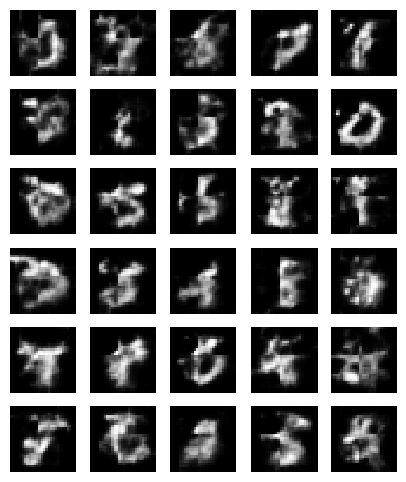

In [58]:
prototype_distances = model.prototype_layer.prototype_distances
# decode prototype vectors
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

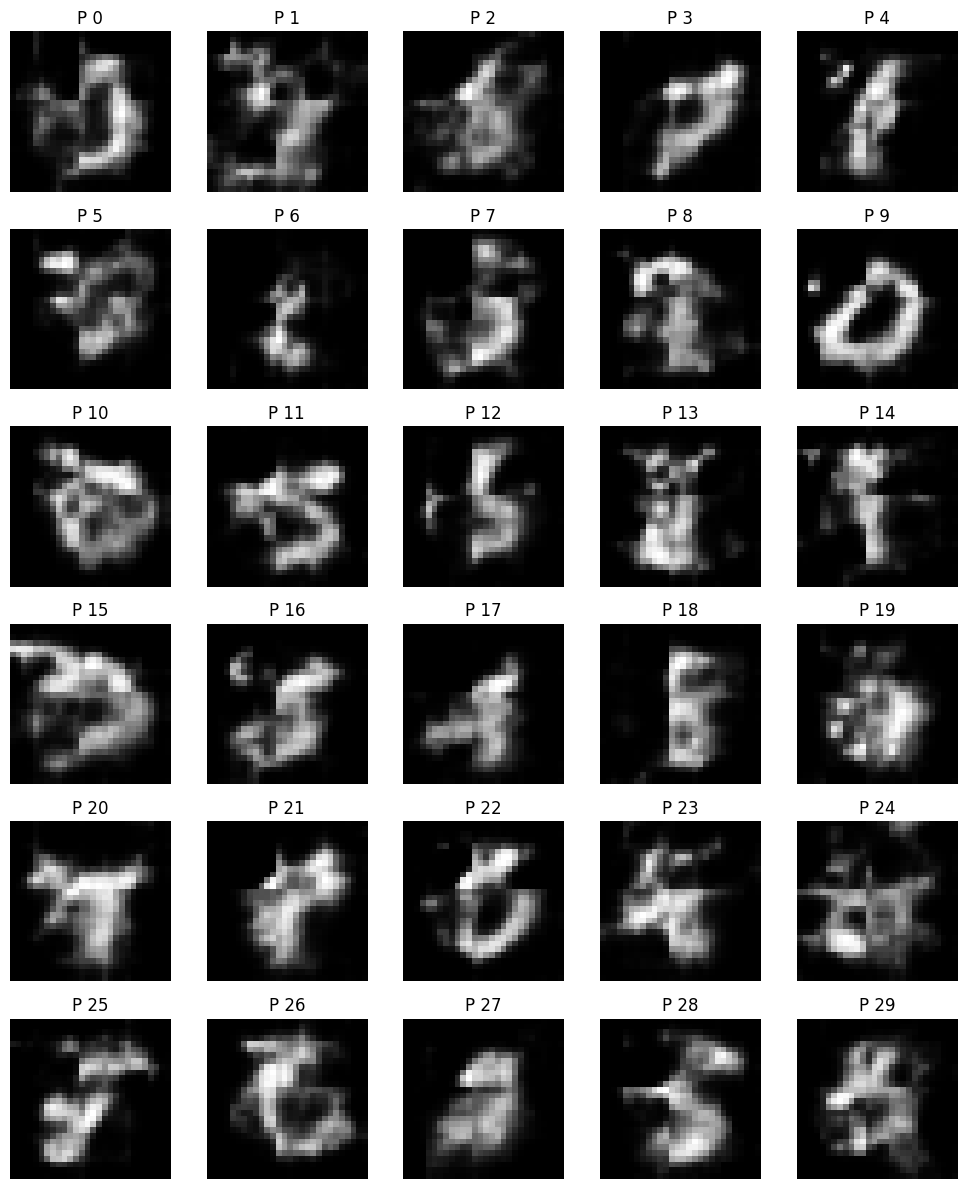

In [59]:
import matplotlib.pyplot as plt
import torch

# Asegurar que los prototipos están en CPU y convertir a numpy
prototype_imgs_np = prototype_imgs.squeeze().detach().cpu().numpy()

# Parámetros de la cuadrícula
n_prototypes = prototype_imgs_np.shape[0]
n_cols = 5
n_rows = (n_prototypes // n_cols) + (1 if n_prototypes % n_cols != 0 else 0)

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < n_prototypes:
        ax.imshow(prototype_imgs_np[i], cmap='gray', interpolation='none')
        ax.set_title(f"P {i}")  # Puedes cambiar el título si quieres agregar más info
        #ax.set_title(f"Clase {prototype_classes[i].item()}")

        ax.axis("off")

    else:
        ax.axis("off")  # Apagar ejes para celdas vacías

plt.tight_layout()
plt.show()


### Imágenes reales y su reconstrucción

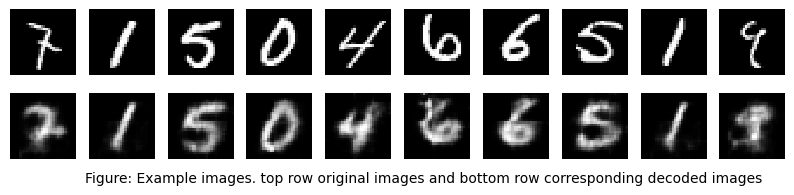

In [45]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()


# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')

f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()

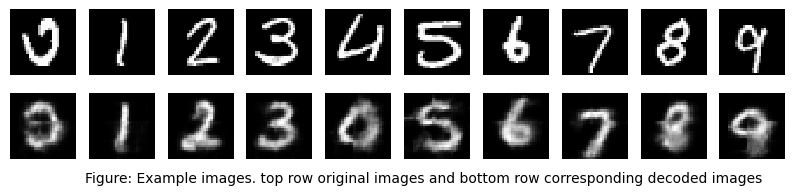

,0,1,2,3,4,5,6,7,8,9
0,0.644043,-0.995120,6.177418,-1.017309,-0.019422,-8.556418,-8.446063,-6.210902,-1.090054,-5.530853
1,-0.403726,-2.586667,0.325695,-5.565667,-1.155780,0.699913,-2.406234,0.817850,-5.548157,-3.210601
2,3.401979,-5.009641,0.550744,-3.941143,-5.017413,-1.405421,-9.187001,-0.993452,-5.666892,-3.732495
3,4.846101,-4.493955,-2.684720,-9.003722,-9.035285,-5.015641,-16.094976,1.757629,-6.836822,-3.265807
4,-0.954255,-0.567950,1.808076,-1.263171,-3.177024,-5.879455,-11.316321,3.811362,-5.750906,-2.146345
5,-1.267921,-1.529180,3.943977,-7.784091,-5.809206,-10.028304,-0.784713,-0.500059,-1.635269,-2.698553
6,-1.800899,1.185090,0.876650,-0.610986,-4.878396,-2.628043,-7.856587,1.894372,-2.712766,-4.128016
7,1.127687,-13.734158,4.409382,-7.262824,-3.174926,-5.505953,-1.844782,-4.880061,2.114132,-6.524503
8,2.274599,2.609084,-0.454344,-3.305359,-3.908088,-6.617052,-9.048574,2.241502,-5.915329,-0.365409
9,2.618301,-2.068927,4.102402,-2.128837,-7.726178,-7.932705,-8.233579,0.117609,-3.436872,-3.686512


In [46]:
import pandas as pd
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break
    
pred_y = model.forward(batch_x)

pred_y_np = pred_y.detach().cpu().numpy() 
batch_y_np = batch_y.detach().cpu().numpy()
labels = []
data = []
idx = []
i = 0
j = 0
for l in batch_y_np:
    if(i==10):
        break
    if l==i:
        labels.append(l)
        data.append(pred_y_np[j])
        idx.append(j)
        i = i+1
    j = j + 1
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
examples_to_show = 10
        
encoded = model.encoder.forward(batch_x)
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu() 

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
j = 0
for i in idx:
    a[0][j].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][j].axis('off')
    a[1][j].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][j].axis('off')
    j = j + 1
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
plt.show()
plt.close()
    
df = pd.DataFrame(data, labels, classes)
df.style.format(precision=2)
df.style.highlight_max(props='background-color:red;color:white;', axis=1)




# Examples of test

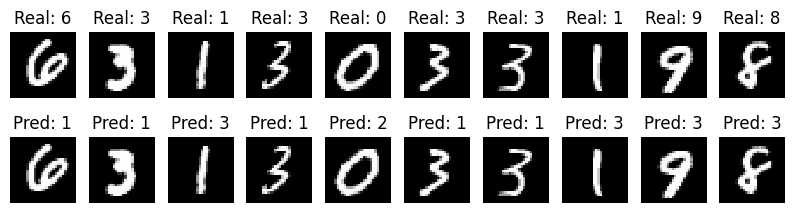

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000975,0.894809,0.001256,0.005840,0.001823,0.005468,0.005518,0.043648,0.012937,0.027725
Example 1,0.000402,0.994170,0.004755,0.000422,0.000002,0.000014,0.000002,0.000213,0.000000,0.000021
Example 2,0.186611,0.003979,0.108243,0.591039,0.000183,0.001046,0.001349,0.080848,0.001537,0.025164
Example 3,0.012223,0.910418,0.009920,0.003956,0.000169,0.000459,0.000119,0.060224,0.000001,0.002512
Example 4,0.000369,0.043153,0.495966,0.332725,0.000113,0.059835,0.063237,0.003651,0.000852,0.000098
Example 5,0.001618,0.983469,0.001376,0.001092,0.000005,0.000536,0.000016,0.011555,0.000000,0.000333
Example 6,0.000248,0.933958,0.000754,0.007484,0.000324,0.000106,0.000003,0.052529,0.000002,0.004591
Example 7,0.000965,0.000031,0.002655,0.995105,0.000000,0.000404,0.000039,0.000061,0.000098,0.000642
Example 8,0.000049,0.004664,0.001798,0.987762,0.000000,0.000864,0.000006,0.003675,0.000043,0.001139
Example 9,0.000509,0.000121,0.002098,0.915866,0.000011,0.075362,0.000244,0.001688,0.000845,0.003254


In [37]:
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

with torch.no_grad():
    pred_y = model(batch_x) 

pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2.5))

for i in range(examples_to_show):
    # imagen original
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # clase predicha
    predicted_class = pred_y_np[i].argmax()
    axes[1, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f" \nPred: {predicted_class}")

plt.show()

df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])

df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df

#with torch.no_grad():
#    pred_y = model(batch_x)
#    prototype_distances = model.prototype_layer.prototype_distances
#    print("Distancias a prototipos (primeras 5 imágenes):", prototype_distances[:5])


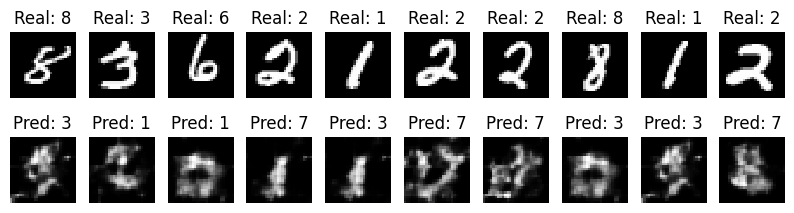

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000228,0.000161,0.000334,0.836407,0.000003,0.118098,0.000011,0.000825,0.001596,0.042336
Example 1,0.001203,0.422472,0.005210,0.349271,0.000477,0.008628,0.000041,0.188125,0.000138,0.024435
Example 2,0.000152,0.687955,0.000160,0.094543,0.000025,0.137094,0.002603,0.060434,0.001516,0.015519
Example 3,0.000455,0.385896,0.062413,0.002882,0.049529,0.002544,0.007401,0.487402,0.001192,0.000287
Example 4,0.000546,0.046072,0.010032,0.905506,0.000001,0.000243,0.000081,0.036608,0.000043,0.000867
Example 5,0.000053,0.261630,0.005052,0.000317,0.001011,0.000001,0.000027,0.731804,0.000031,0.000073
Example 6,0.000167,0.144901,0.027286,0.001340,0.000796,0.000008,0.000023,0.825392,0.000029,0.000057
Example 7,0.000208,0.003131,0.002424,0.951049,0.000020,0.028211,0.000028,0.006437,0.002917,0.005575
Example 8,0.000482,0.035922,0.009314,0.933328,0.000001,0.005526,0.001120,0.013326,0.000173,0.000808
Example 9,0.000100,0.425843,0.025267,0.000917,0.000770,0.000005,0.000010,0.546872,0.000082,0.000134


In [38]:
# Obtener un batch de test
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Obtener un batch del conjunto de test
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

# Hacer predicciones
with torch.no_grad():
    pred_y = model(batch_x)  # No usar forward() directamente

# Convertir a numpy para análisis
pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

# Obtener probabilidades con softmax
probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

# Seleccionar ejemplos a mostrar
examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2.5))

for i in range(examples_to_show):
    # Mostrar imagen original en la primera fila
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # Obtener la clase predicha
    predicted_class = pred_y_np[i].argmax()

    
    closest_train_example = prototype_distances.argmin(dim=1)  # Índice del ejemplo de entrenamiento más cercano

    # Paso 2: Asignar la clase de ese ejemplo al prototipo
    prototype_classes = batch_y[closest_train_example]

    # Obtener el prototipo más cercano a la clase predicha
    prototype_image = prototype_imgs[prototype_classes].cpu().squeeze()



    # Mostrar el prototipo en la segunda fila
    axes[1, i].imshow(prototype_image[i], cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Pred: {predicted_class}")

plt.show()

# Crear un DataFrame con probabilidades
df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])

# Resaltar las predicciones más altas
df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df
